In [1]:
# !pip install yellowbrick

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
plt.style.use('fivethirtyeight')

# 통계분석
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# 차원축소
from sklearn.preprocessing import *
from sklearn.decomposition import TruncatedSVD, PCA

# 군집화
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster 
from sklearn_extra.cluster import KMedoids
from yellowbrick.cluster import KElbowVisualizer

# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

## 군집화
- 군집화 과정 역시, 최종 ppt에서 제시한 데이터를 활용하지 못해(통계청 데이터) 결과가 상이할 수 있음을 참고하자.
- KMaens, GMM, DBSCAN, Hierarchy Clustering을 진행한다.
- 실루엣계수를 비교하여 최종적으로 KMeans Clustering 기법을 선택하여 최종 서비스 대상 군집으로 선택한다.

In [3]:
def silhouette_avg(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    return cluster_labels, yticks, silhoutte_avg

### KMeans
- k가 2 혹은 3일 경우 가장 안정적인 실루엣 계수 분포를 보인다.
- 2개는 나누어지는 군집의 개수가 너무 적다고 판단하여 3개로 최종 결정하였다.

In [4]:
pca_result = pd.read_csv('./data_to_model/data_after_pca_20231020.csv', index_col=0)

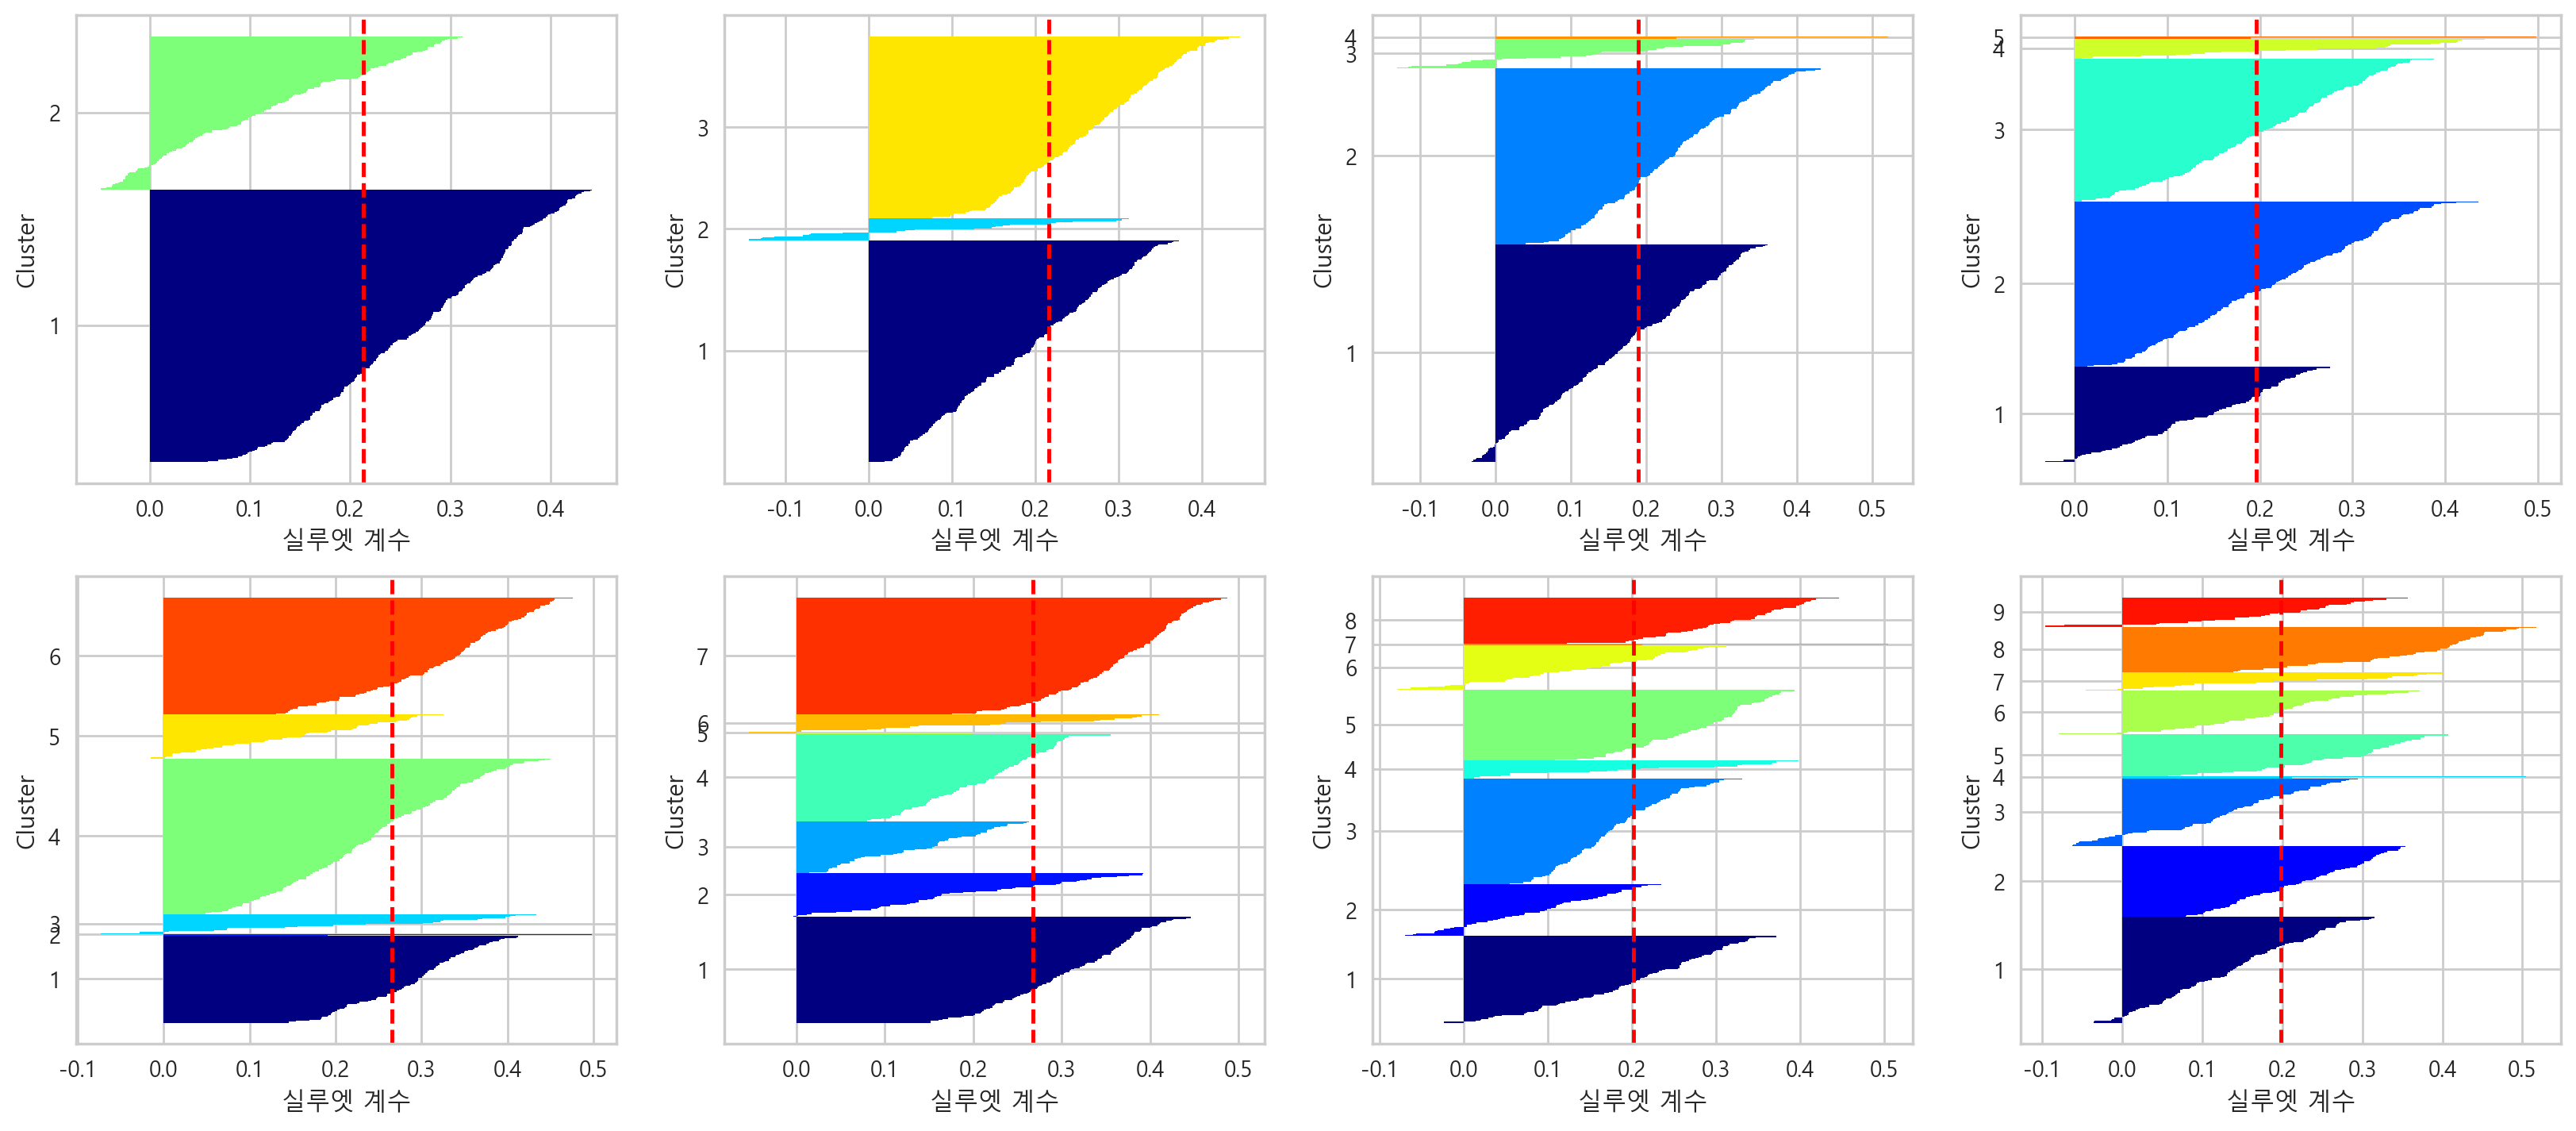

In [5]:
# 군집의 개수를 2~9까지 바꿔가며 최적의 군집 개수를 선택한다.
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows,
                       ncols=ncols,
                       figsize=(18,8))
for i, n_cluster in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=n_cluster,
                    init='k-means++',
                    max_iter=300,
                    random_state=0)
    kmeans.fit(pca_result)

    
    plt.subplot(nrows, ncols, i+1)
    pca_result['cluster'] = kmeans.labels_
    cluster_labels, yticks, silhoutte_score = silhouette_avg(pca_result, kmeans.labels_)
    
    plt.axvline(silhoutte_score, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('Cluster')
    plt.xlabel('실루엣 계수')
plt.show()

In [23]:
pca_result.groupby('cluster').count()

인구가 비교적 적은 지역  1인 세대 및 20~30대 남녀가 많은 지역  미취학 및 초등학생, 젊은 세대가 많은 지역  \
cluster                                                                      
0                  182                       182                       182   
1                   22                        22                        22   
2                    2                         2                         2   
3                  220                       220                       220   

         도시농업 체험 프로그램이 많은 지역  공기질 오염이 심한 지역  공원녹지가 부족한 지역  사업체 및 유동인구가 적은 지역  \
cluster                                                                        
0                        182            182           182                182   
1                         22             22            22                 22   
2                          2              2             2                  2   
3                        220            220           220                220   

         초등학교 및 유치원이 많은 지역  채소 가게 소비가 많은 지역  상가 매출이 많은 곳  초등학교가 많은 지역  
cluster                                                                
0                      182              182          182          182  
1                       22               22           22           22  
2                        2                2            2            2  
3                      220              220          220          220

In [27]:
pca_result[pca_result['cluster'] == 2]

인구가 비교적 적은 지역  1인 세대 및 20~30대 남녀가 많은 지역  미취학 및 초등학생, 젊은 세대가 많은 지역  \
둔촌1동      27.154264                 -0.787448                  1.129912   
반포본동      18.459850                 -2.219277                  0.576948   

      도시농업 체험 프로그램이 많은 지역  공기질 오염이 심한 지역  공원녹지가 부족한 지역  사업체 및 유동인구가 적은 지역  \
둔촌1동            -1.141332       5.524386      6.458191           8.280829   
반포본동            -0.339428       0.699185     -0.015089           4.737938   

      초등학교 및 유치원이 많은 지역  채소 가게 소비가 많은 지역  상가 매출이 많은 곳  초등학교가 많은 지역  cluster  
둔촌1동          -0.505436        -1.853087     0.162599     1.708948        2  
반포본동          -0.429768        -0.532851     0.397205     0.313295        2

In [6]:
kmeans = KMeans(n_clusters=6,
                init='k-means++',
                max_iter=300,
                random_state=0)
kmeans.fit(pca_result)

pca_result['cluster'] = kmeans.labels_

In [7]:
# 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(pca_result.iloc[:,:-1], pca_result['cluster'])
print('silhouette_samples() return 값의 shape: ' , score_samples.shape)

# 실루엣 계수 컬럼 추가
pca_result['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster'])
print('Data의 그룹별 Silhouette Analysis Score:  {0:.3f}'.format(average_score))

print(pca_result.groupby('cluster')['silhouette_coeff'].mean())

silhouette_samples() return 값의 shape:  (426,)
Data의 그룹별 Silhouette Analysis Score:  0.132
cluster
0    0.122726
1    0.103004
2    0.175873
3    0.359769
4    0.062248
5    0.106750
Name: silhouette_coeff, dtype: float64


In [8]:
pca_result[['cluster', 'silhouette_coeff']]

cluster  silhouette_coeff
가락1동        2          0.086245
가락2동        1          0.105709
가락본동        1          0.151969
가리봉동        4          0.203422
가산동         1         -0.037579
...       ...               ...
효창동         4          0.076924
후암동         2          0.118257
휘경1동        0          0.067445
휘경2동        2          0.164778
흑석동         1          0.198074

[426 rows x 2 columns]

In [ ]:
pca_result[pca_result['cluster']==0]

In [ ]:
pca_result[pca_result['cluster']==1]

In [ ]:
pca_result[pca_result['cluster']==2]

### GMM
- 군집의 개수가 2개일 경우 가장 최선
- 3개 이상이 될 경우, 실루엣 계수가 안정적이지 않다.
- 더불어, 군집을 2개로 나누는 것은 군집의 개수가 적다고 판단.

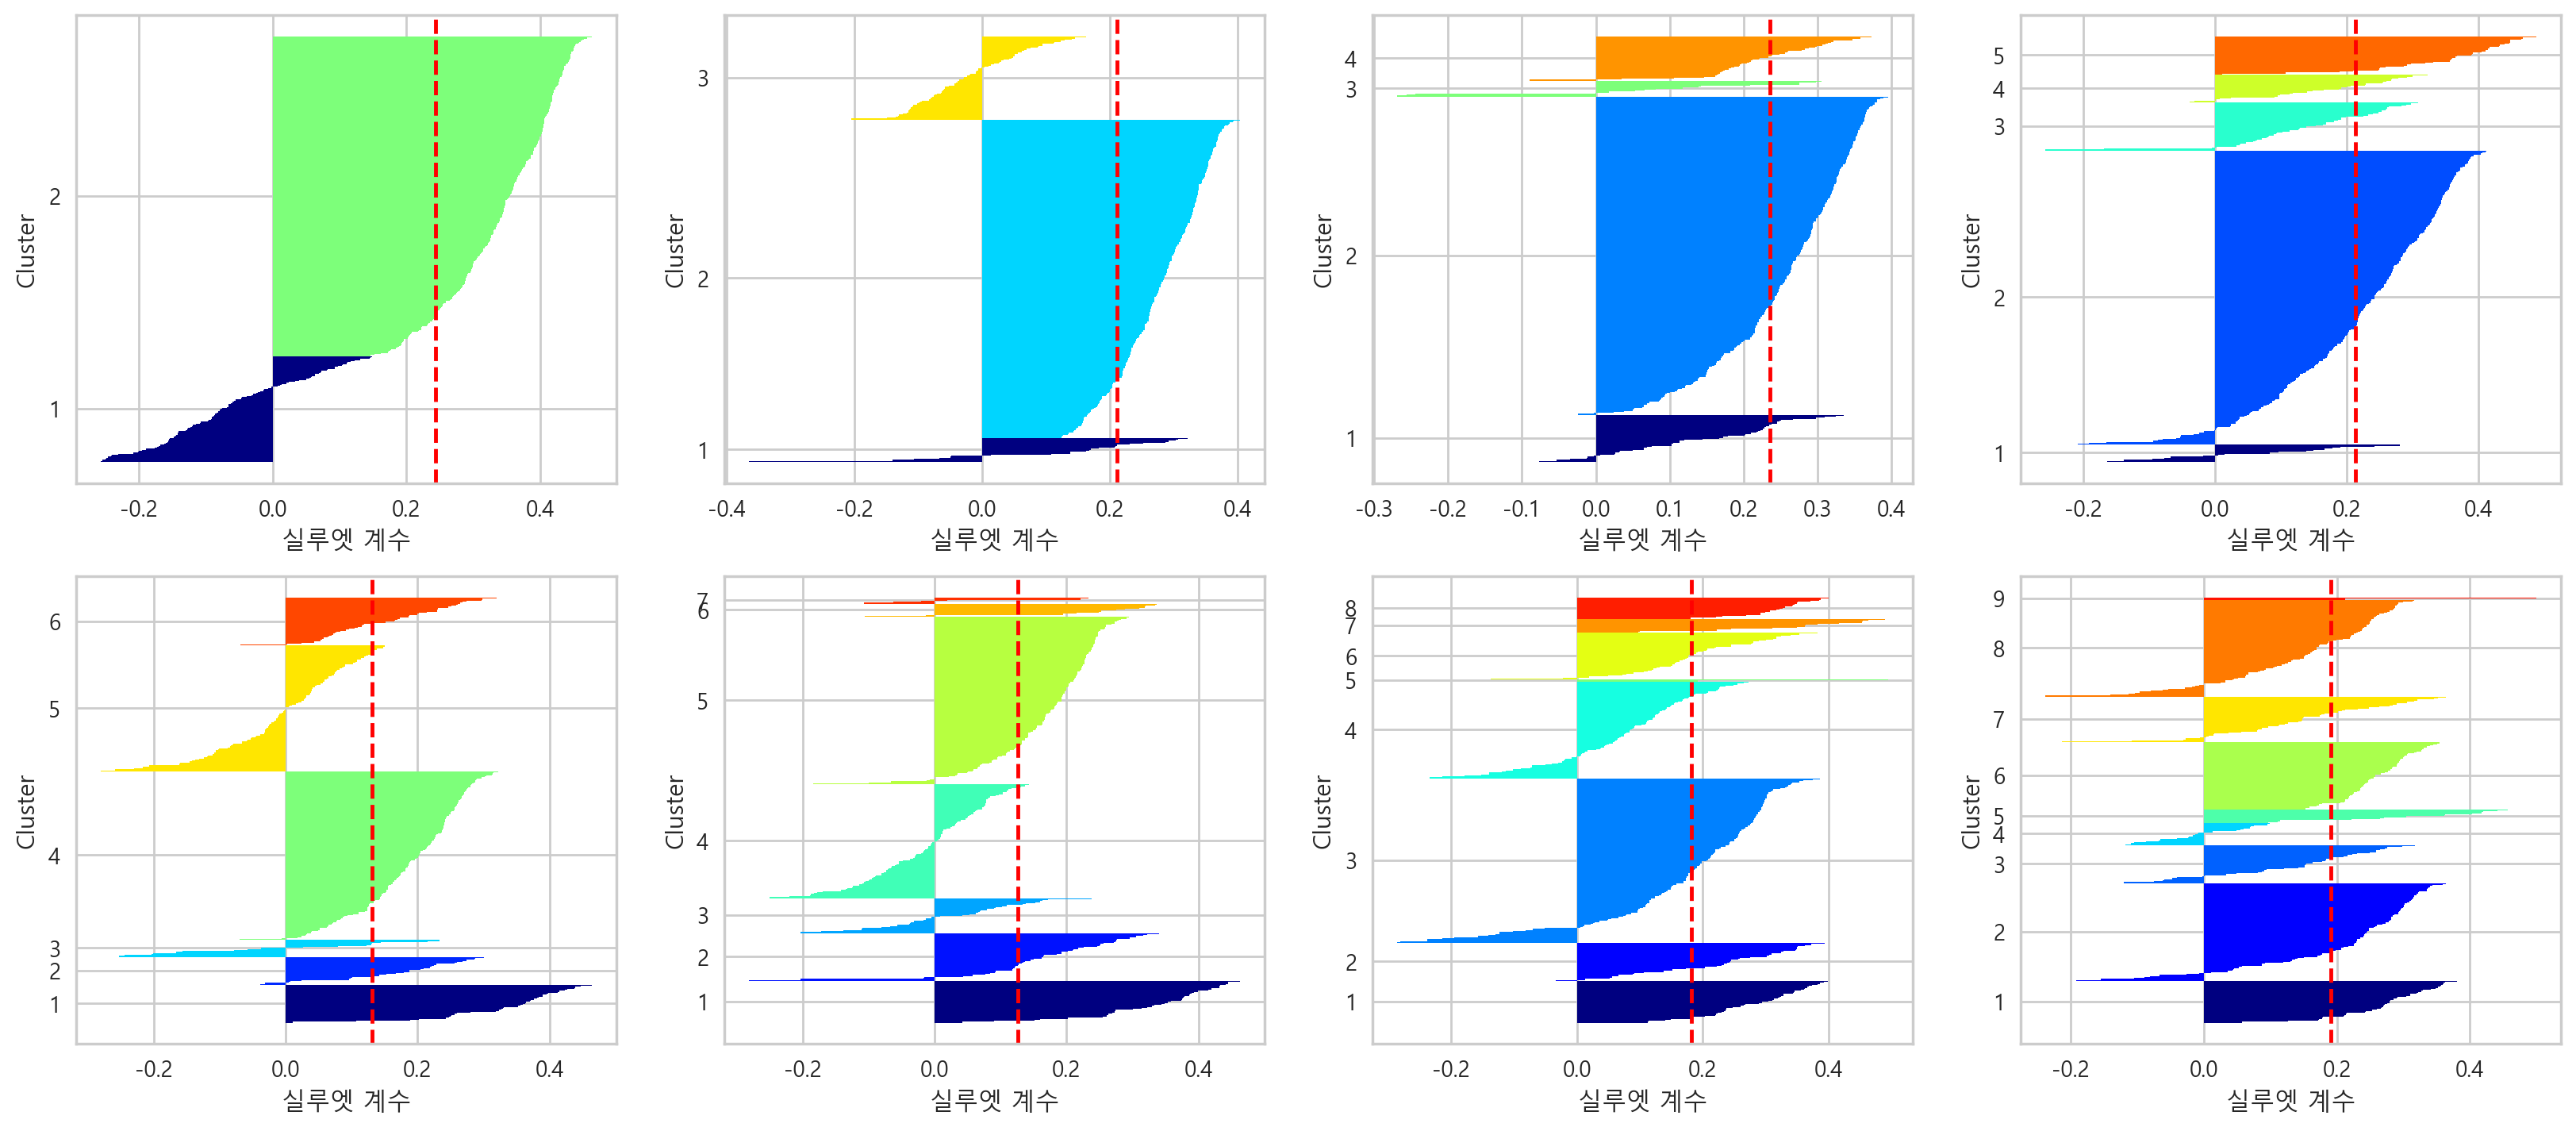

In [9]:
# 군집의 개수를 2~9까지 바꿔가며 최적의 군집 개수를 선택한다.
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows,
                       ncols=ncols,
                       figsize=(18,8))
for i, n_cluster in enumerate(n_clusters):
    gmm=GaussianMixture(n_components=n_cluster, random_state=0).fit(pca_result)
    gmm_cluster_label=gmm.predict(pca_result)

    plt.subplot(nrows, ncols, i+1)
    pca_result['cluster'] = gmm_cluster_label
    cluster_labels, yticks, silhoutte_score = silhouette_avg(pca_result, gmm_cluster_label)
    
    plt.axvline(silhoutte_score, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('Cluster')
    plt.xlabel('실루엣 계수')
plt.show()

In [10]:
gmm=GaussianMixture(n_components=2, random_state=0).fit(pca_result)
gmm_cluster_label=gmm.predict(pca_result)

pca_result['cluster_label']=gmm_cluster_label

In [11]:
# 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(pca_result.iloc[:,:-2], pca_result['cluster_label'])
print('silhouette_samples( ) return 값의 shape: ' , score_samples.shape)

# 실루엣 계수 컬럼 추가
pca_result['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster_label'])
print('Data의 그룹별 Silhouette Analysis Score:  {0:.3f}'.format(average_score))

print(pca_result.groupby('cluster_label')['silhouette_coeff'].mean())

silhouette_samples( ) return 값의 shape:  (426,)
Data의 그룹별 Silhouette Analysis Score:  0.245
cluster_label
0    0.322420
1    0.178511
Name: silhouette_coeff, dtype: float64


### DBSCAN
- DBSCAN을 활용할 경우, 군집이 제대로 나누어지지 않음.

In [12]:
dbscan=DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_cluster_label=dbscan.fit_predict(pca_result)

pca_result['cluster_label']=dbscan_cluster_label
pca_result['cluster_label'].value_counts()

cluster_label
-1    426
Name: count, dtype: int64

### Hierarchical Clustering

- 다소 균등하게 군집이 나누어짐을 확인.
- KMeans에 비해, 실루엣 계수의 안정성이 떨어짐

In [13]:
clusters = linkage(y=pca_result, method='complete', metric='euclidean')
clusters.shape 

(425, 4)

In [14]:
cut_tree = fcluster(clusters, t=11, criterion='distance')
pca_result['cluster_label']=cut_tree # prediction

pca_result['cluster_label'].value_counts()

cluster_label
3    137
5    100
7     99
6     44
4     30
8     13
1      1
2      1
9      1
Name: count, dtype: int64

In [15]:
# 모든 개별 데이터에 실루엣 계수값을 구함.
score_samples = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster_label'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# 실루엣 계수 컬럼 추가
pca_result['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster_label'])
print('dpca_resultult 그룹별 Silhouette Analysis Score:{0:.3f}'.format(average_score))

print(pca_result.groupby('cluster_label')['silhouette_coeff'].mean())

silhouette_samples( ) return 값의 shape ()
dpca_resultult 그룹별 Silhouette Analysis Score:0.270
cluster_label
1    0.270235
2    0.270235
3    0.270235
4    0.270235
5    0.270235
6    0.270235
7    0.270235
8    0.270235
9    0.270235
Name: silhouette_coeff, dtype: float64


In [18]:
pca_result['cluster_label'].unique()

array([3, 6, 5, 7, 8, 4, 1, 2, 9])

## 최종 군집 선택

다음의 분석으로부터 최종 군집과 그 특성들을 확인할 수 있다.

- 0번 군집 : 소득수준과 인구가 낮고 식당가도 없어 유동인구가 낮아보이며 주위에 대형마트의 비율이 높은 노년인구가 많은 외곽지역의 오래된 5일장  
- 1번 군집 :  소득수준과 인구가 높은 점포수가 적은 현대화된 시장 하지만 특이 품목을 파는 시장은 아님
- 2번 군집 :  도심 중심 업무 지구에 위치하고 젊은층의 인구가 많으며 주변에 대형마트가 적은 시장
- 3번 군집 :  규모와 시설이 낙후되지 않았지만 도보이용이 힘든 외곽의 주거 지구에 위치한 시장

**Note:** 본 과정은 최종 제출한 PPT와 데이터의 차이(통계청 제공 데이터(공개불가))가 있어 결과가 다르므로 데이터 분석의 흐름만 참고하도록 한다. 더불어, 통계청 제공 데이터의 원시데이터는 없으며, 이를 활용한 분석의 결과물이 존재하므로 data folder에 존재하는 data를 활용하여 이후의 분석을 진행해보도록 한다.

In [28]:
pca_result = pd.read_csv('./data_to_model/data_after_pca_20231020.csv', index_col=0)
pca_result.fillna(0, inplace=True)

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(pca_result)

pca_result['cluster'] = kmeans.labels_

In [29]:
# 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(pca_result.iloc[:,:-1], pca_result['cluster'])
print('silhouette_samples() return 값의 shape: ' , score_samples.shape)

# 실루엣 계수 컬럼 추가
pca_result['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(pca_result.iloc[:,:-2], pca_result['cluster'])
print('Data의 그룹별 Silhouette Analysis Score:  {0:.3f}'.format(average_score))

print(pca_result.groupby('cluster')['silhouette_coeff'].mean())

silhouette_samples() return 값의 shape:  (426,)
Data의 그룹별 Silhouette Analysis Score:  0.184
cluster
0    0.136635
1    0.224652
2    0.341092
3    0.216741
Name: silhouette_coeff, dtype: float64


In [30]:
pca_result['cluster'].to_frame().to_csv('./행정동클러스터시각화1020.csv')

In [37]:
def histplot(data, row_num, col_num) :
    fig, ax = plt.subplots(ncols = col_num, figsize = (18,3))
    rep = int(len(data.columns) / col_num)
    
    for i in range(col_num) :
        sns.kdeplot(data.iloc[:, row_num + (rep * i)], ax = ax[i])
        ax[i].set_title(data.iloc[:, row_num + (rep * i)].name)

### 첫번째 Group

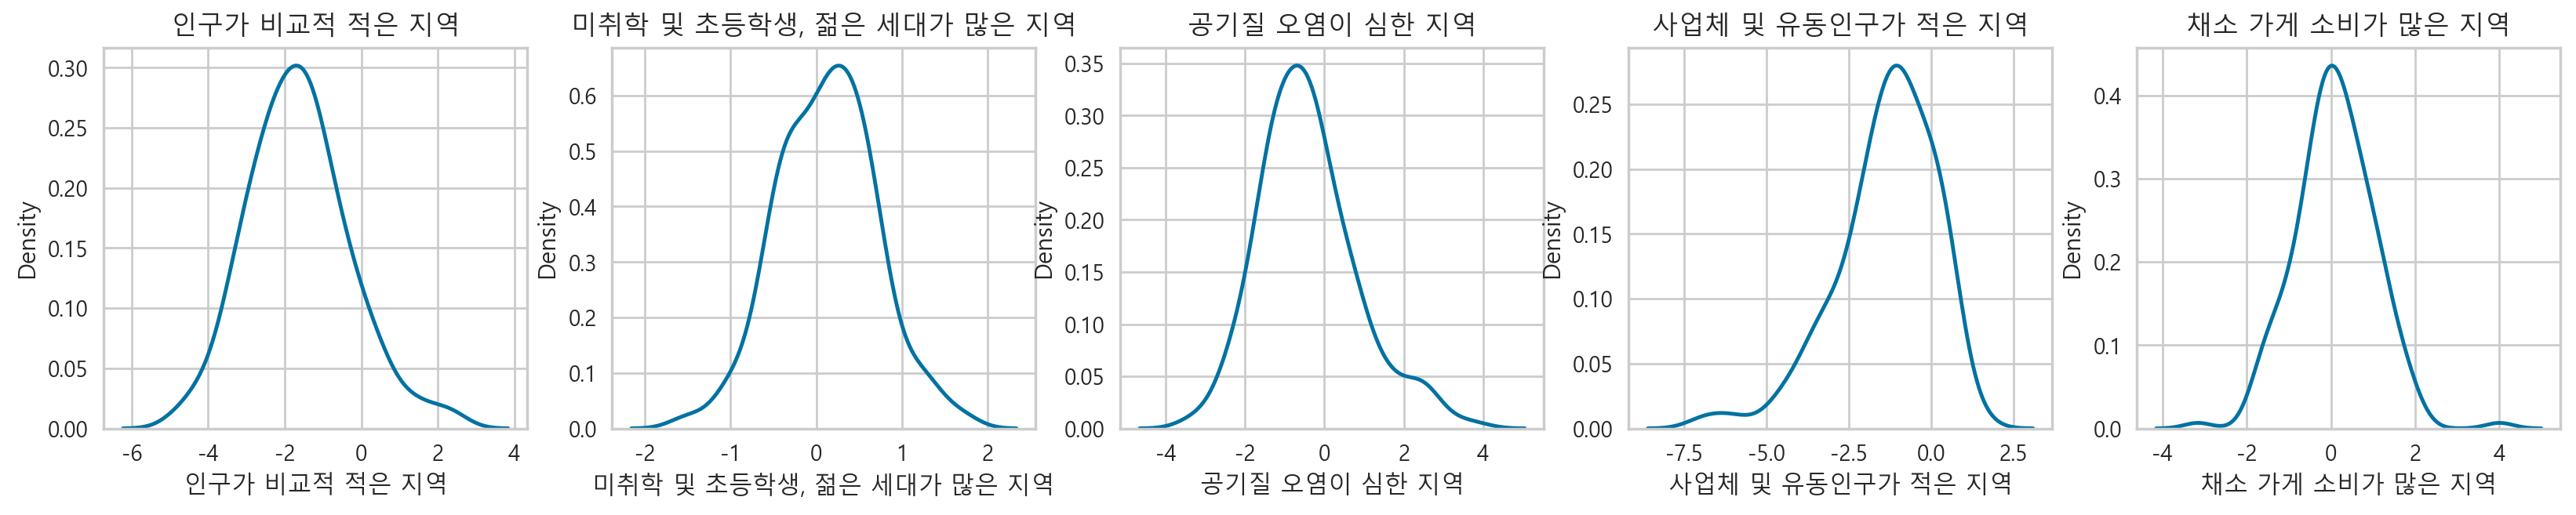

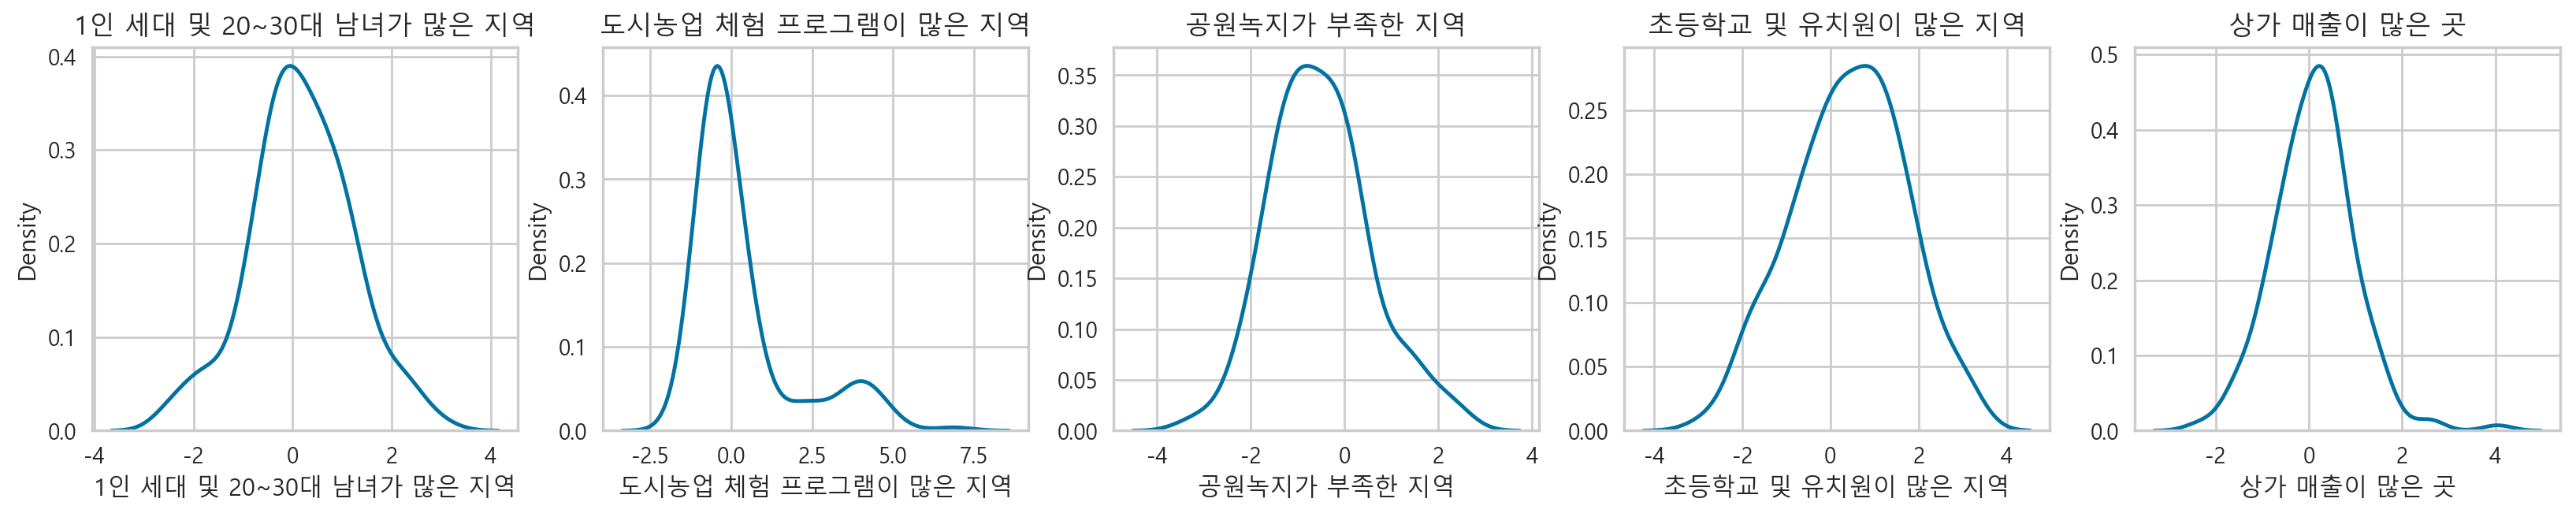

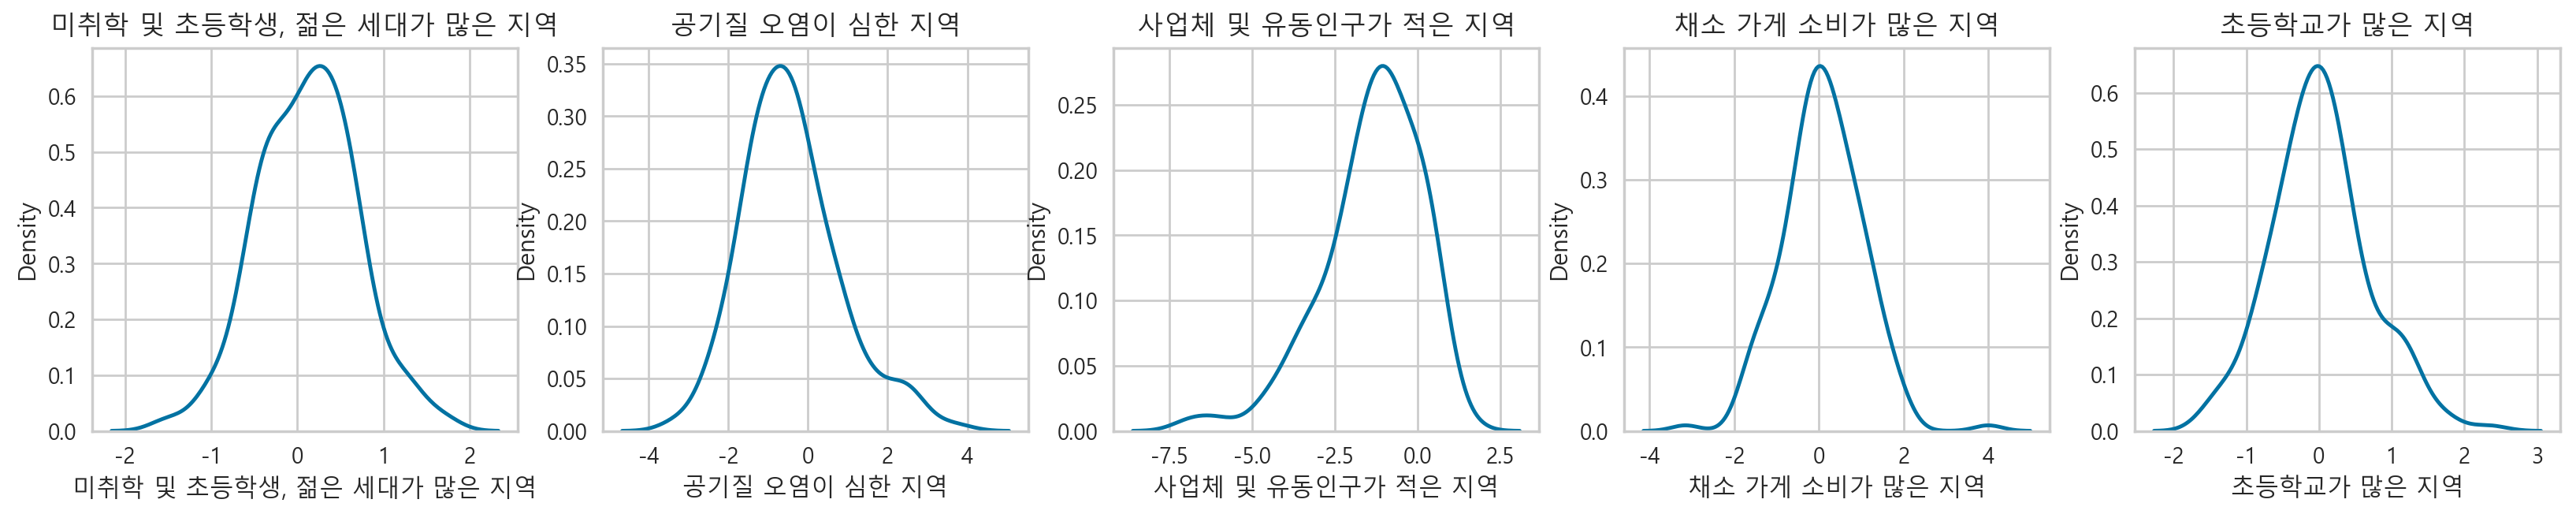

In [38]:
first_group = pca_result[pca_result['cluster'] == 0]
first_group.drop(['silhouette_coeff'], axis = 1, inplace = True)

for row_num in range(3) :
    histplot(first_group.drop(['cluster'], axis = 1), row_num, 5)

### 두번째 Group

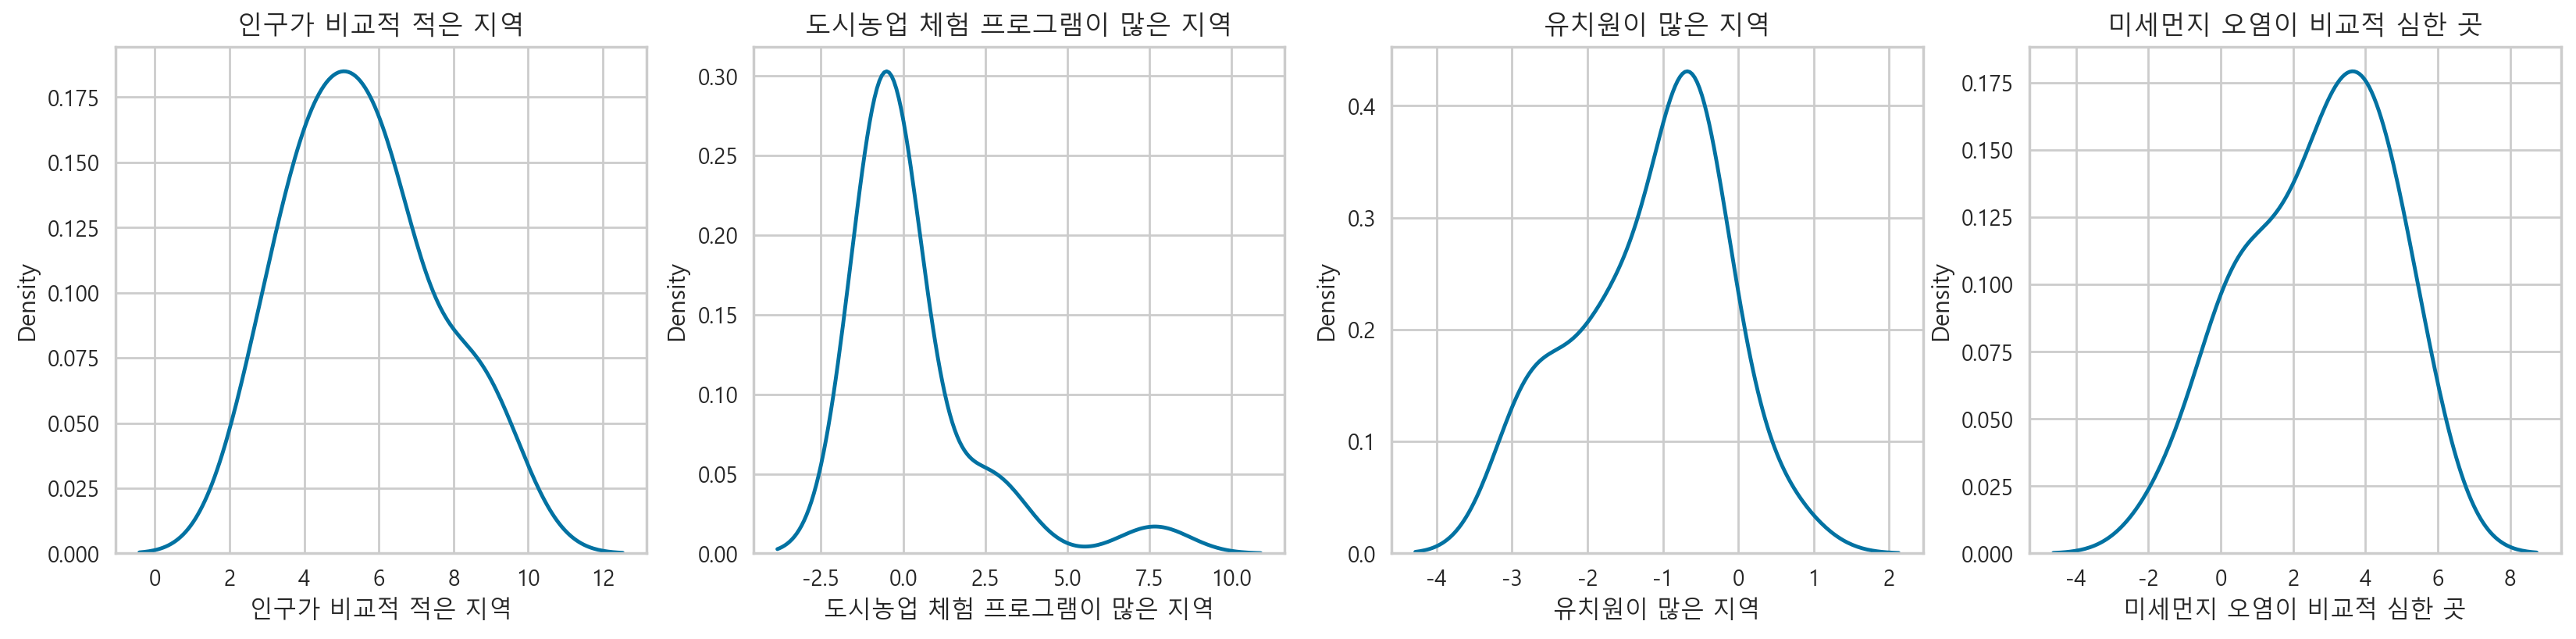

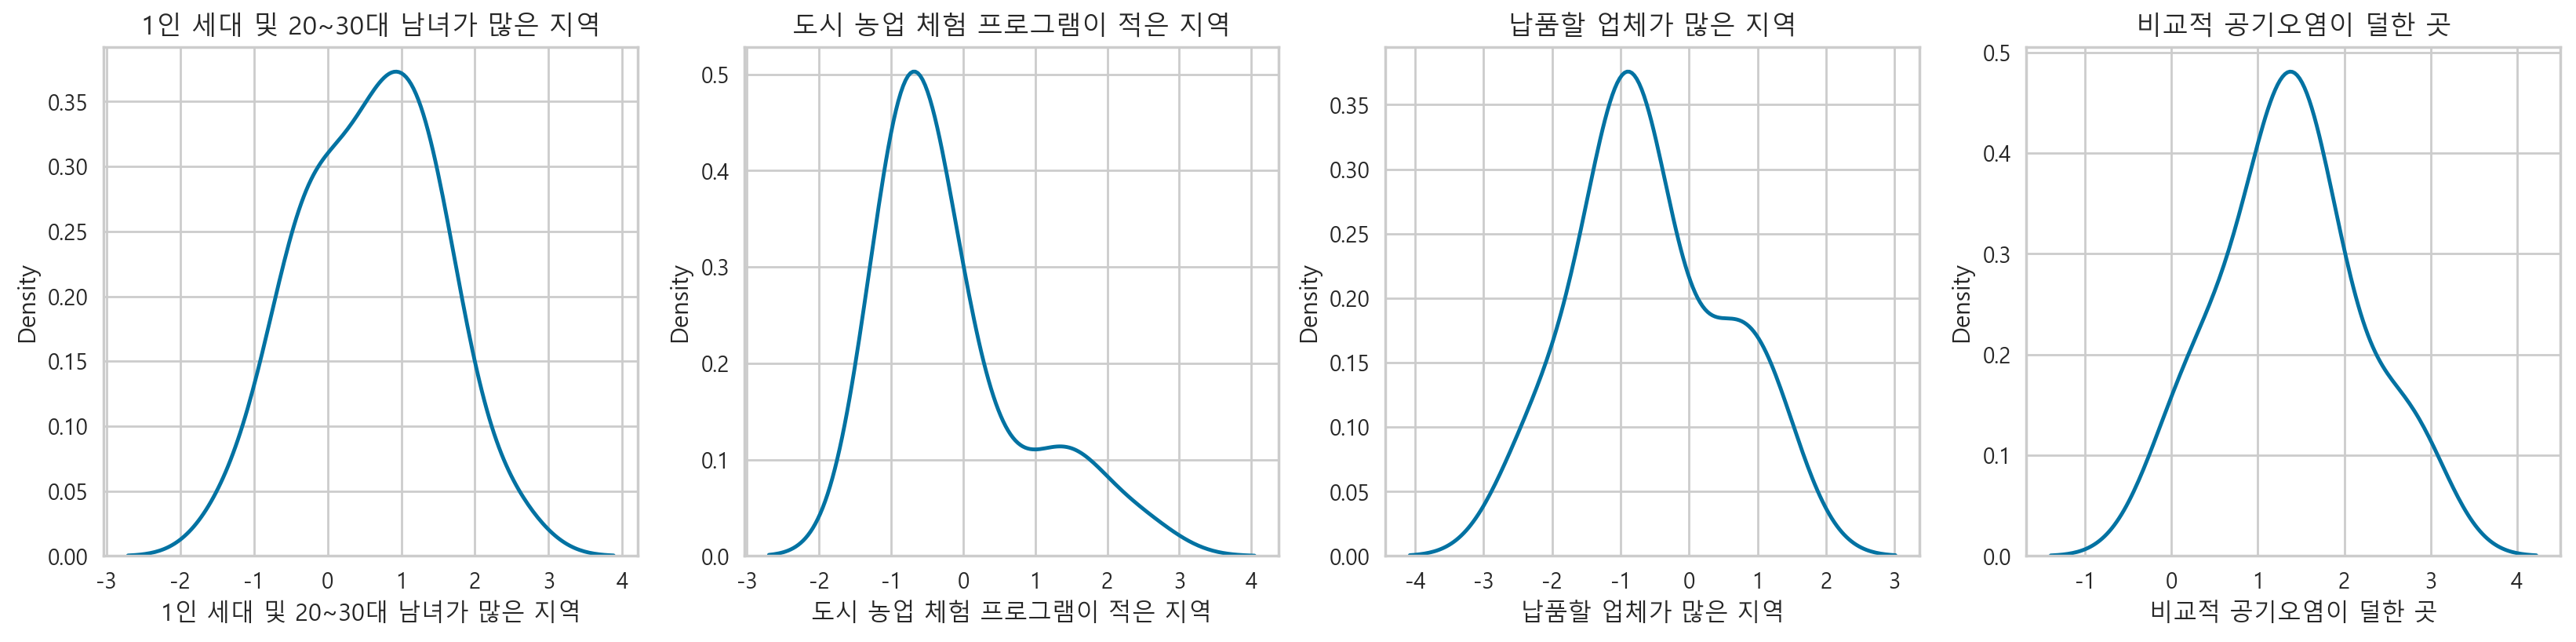

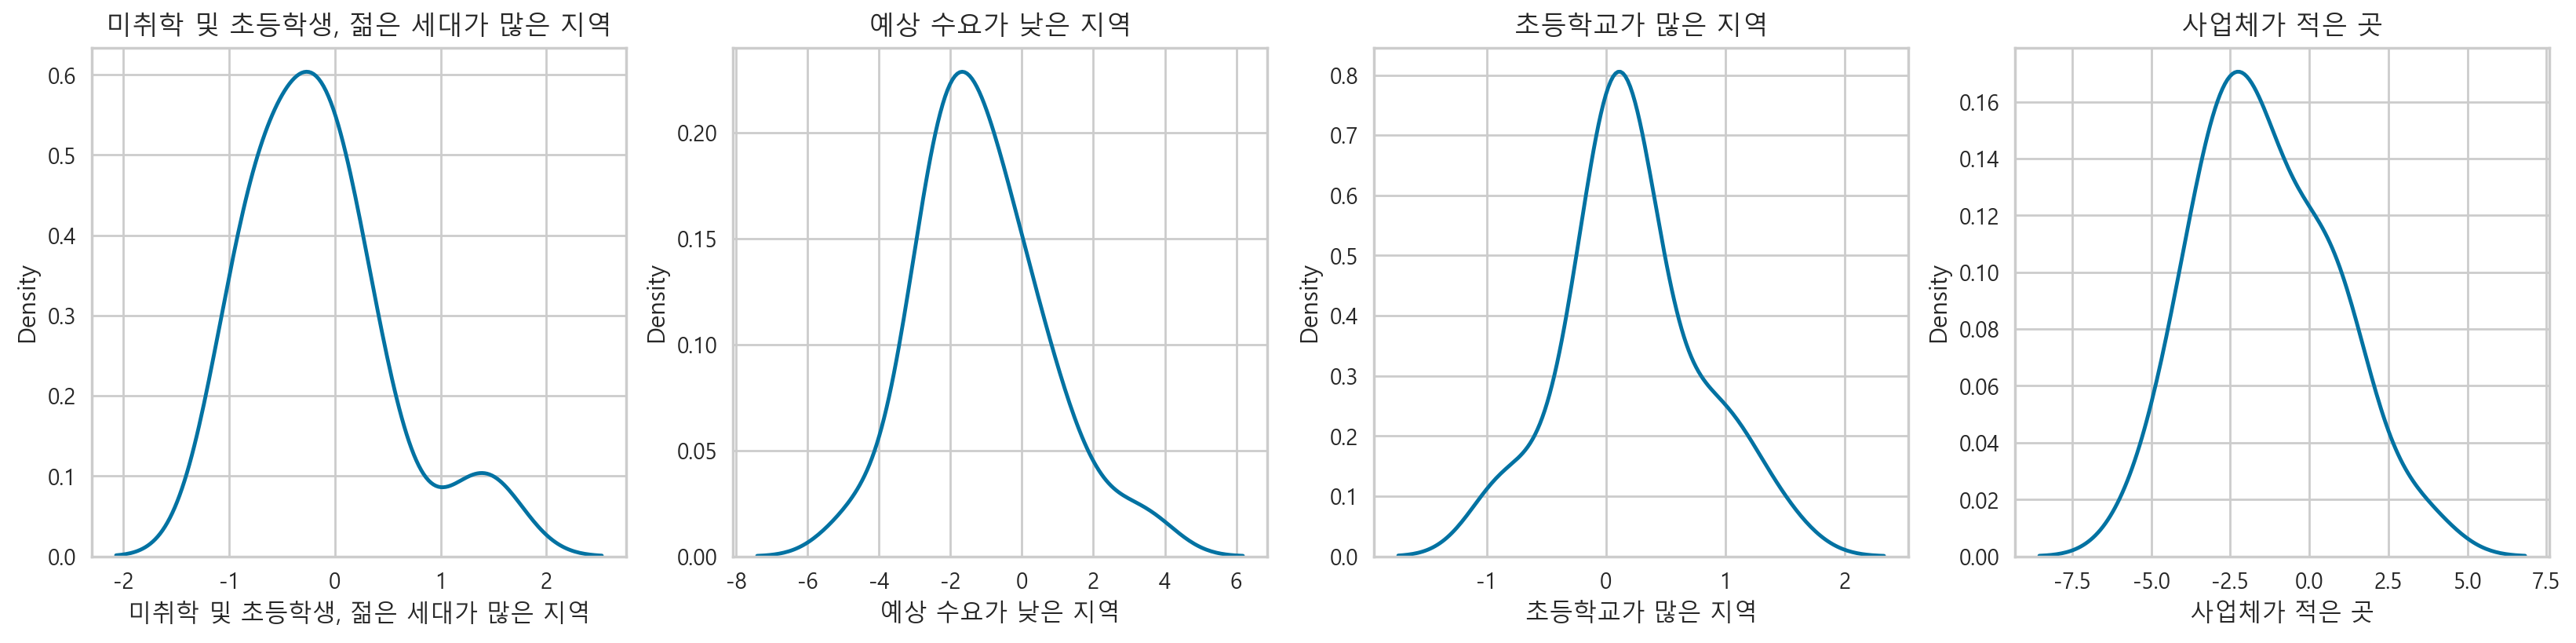

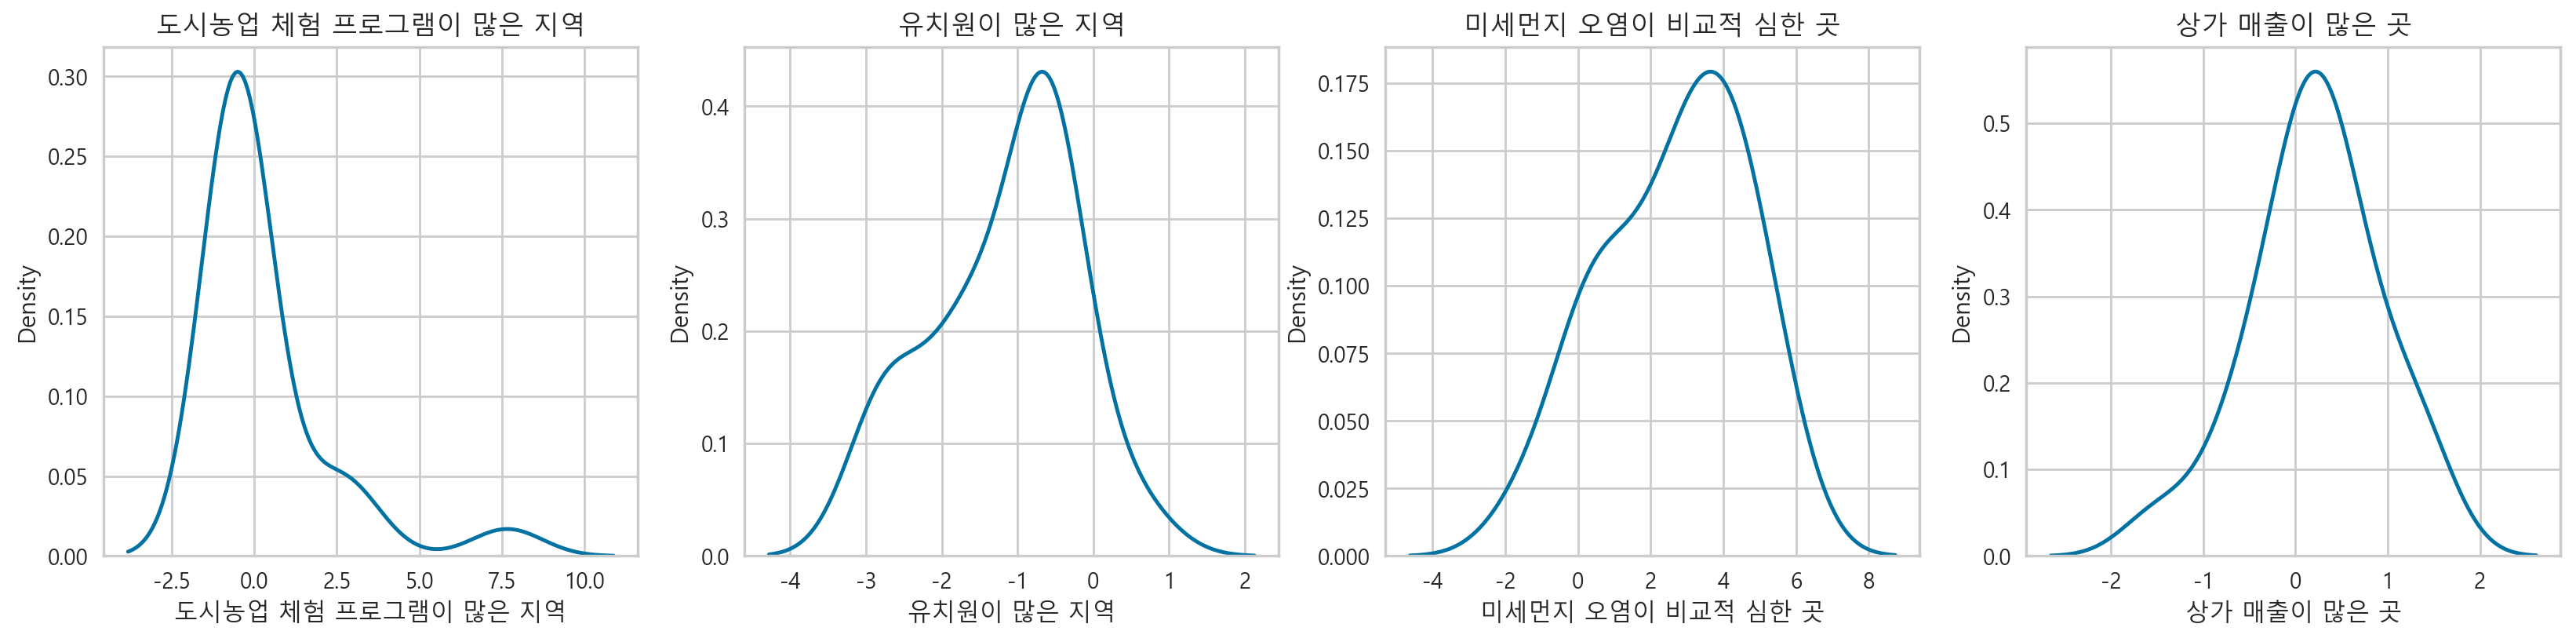

In [25]:
second_group = pca_result[pca_result['cluster'] == 1]
second_group.drop(['silhouette_coeff'], axis = 1, inplace = True)

for row_num in range(4) :
    histplot(second_group.drop(['cluster'], axis = 1), row_num, 4)

### 세번째 Group

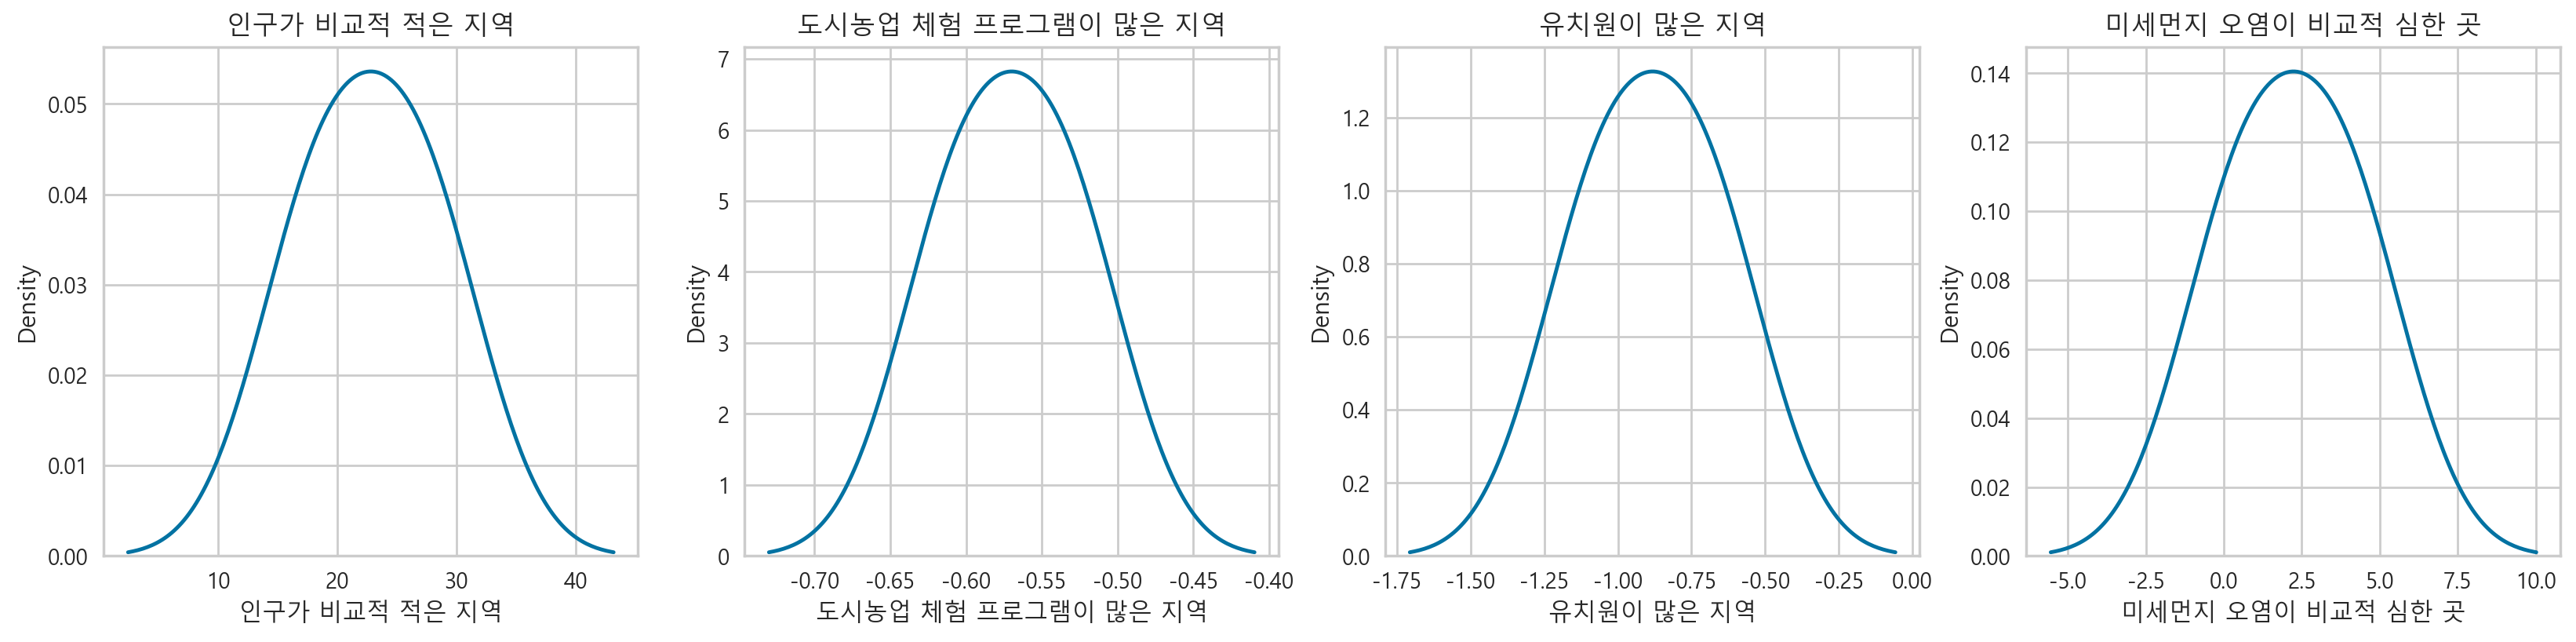

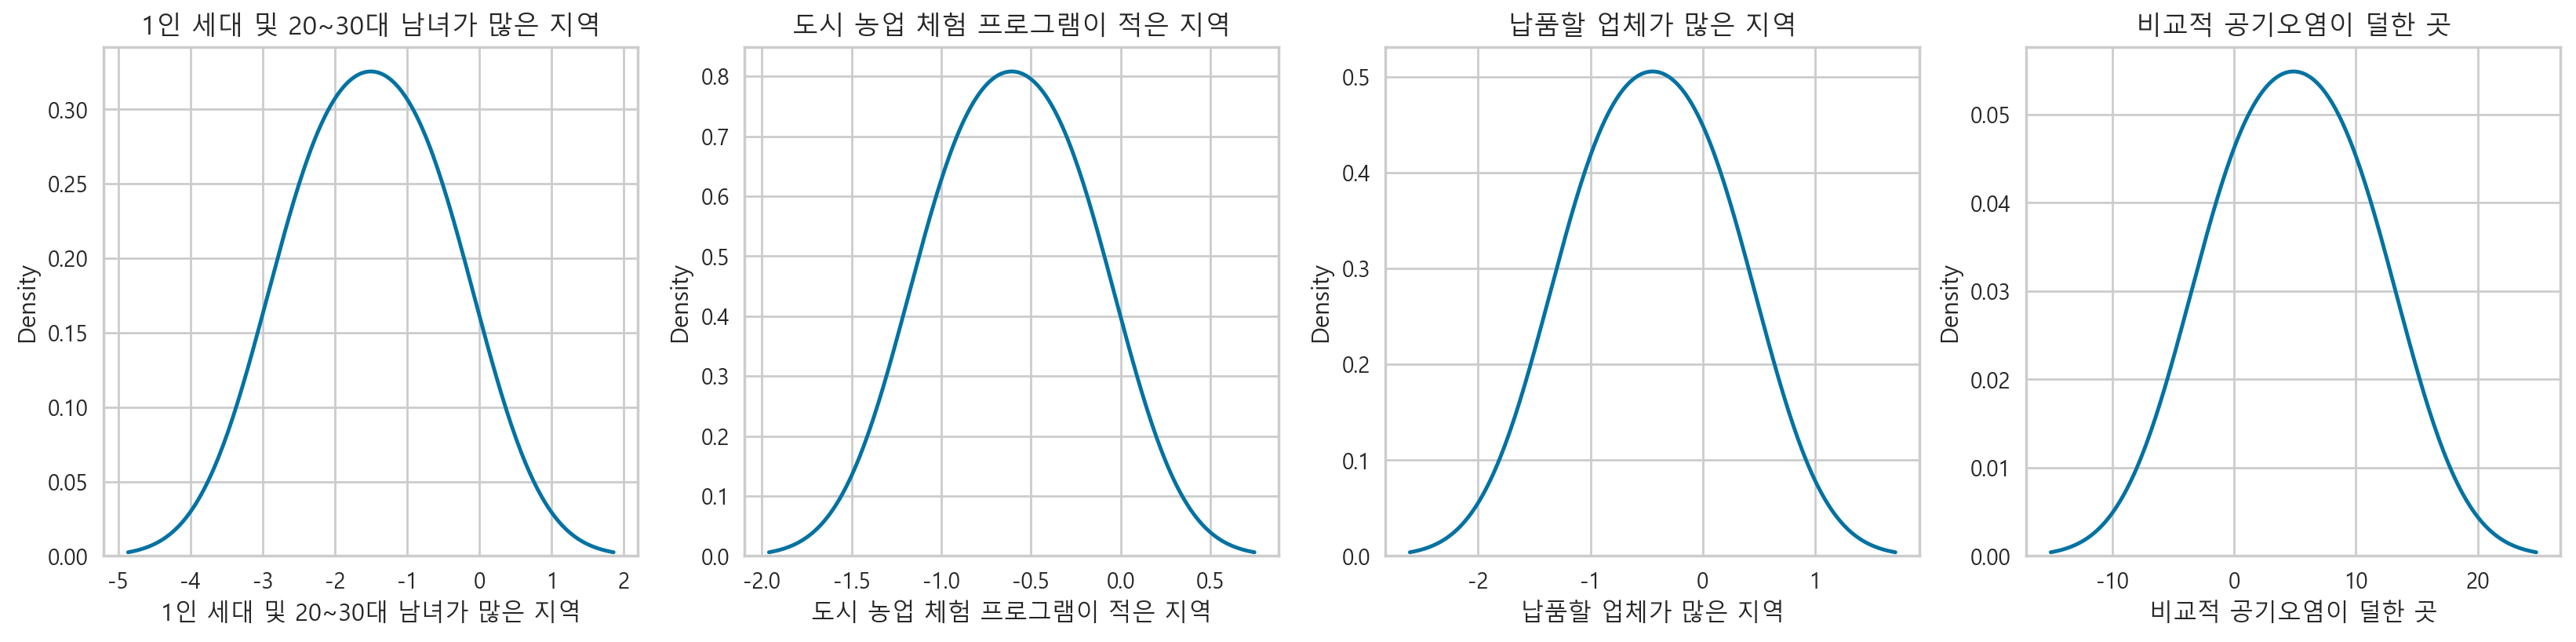

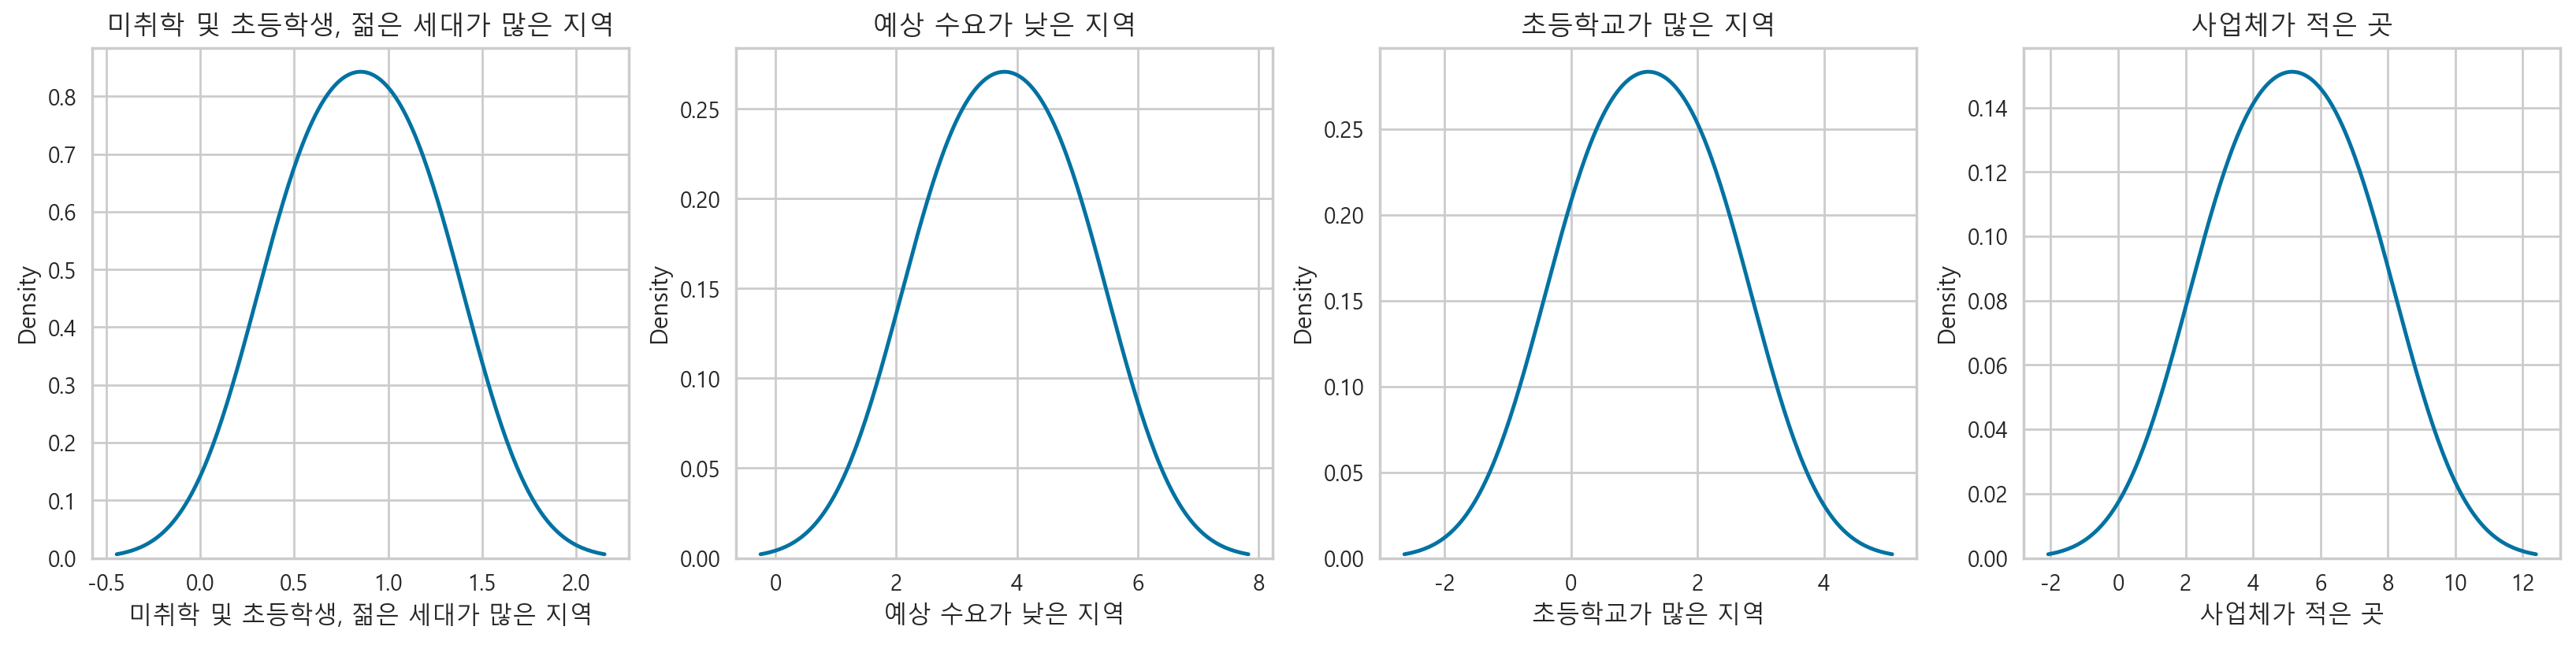

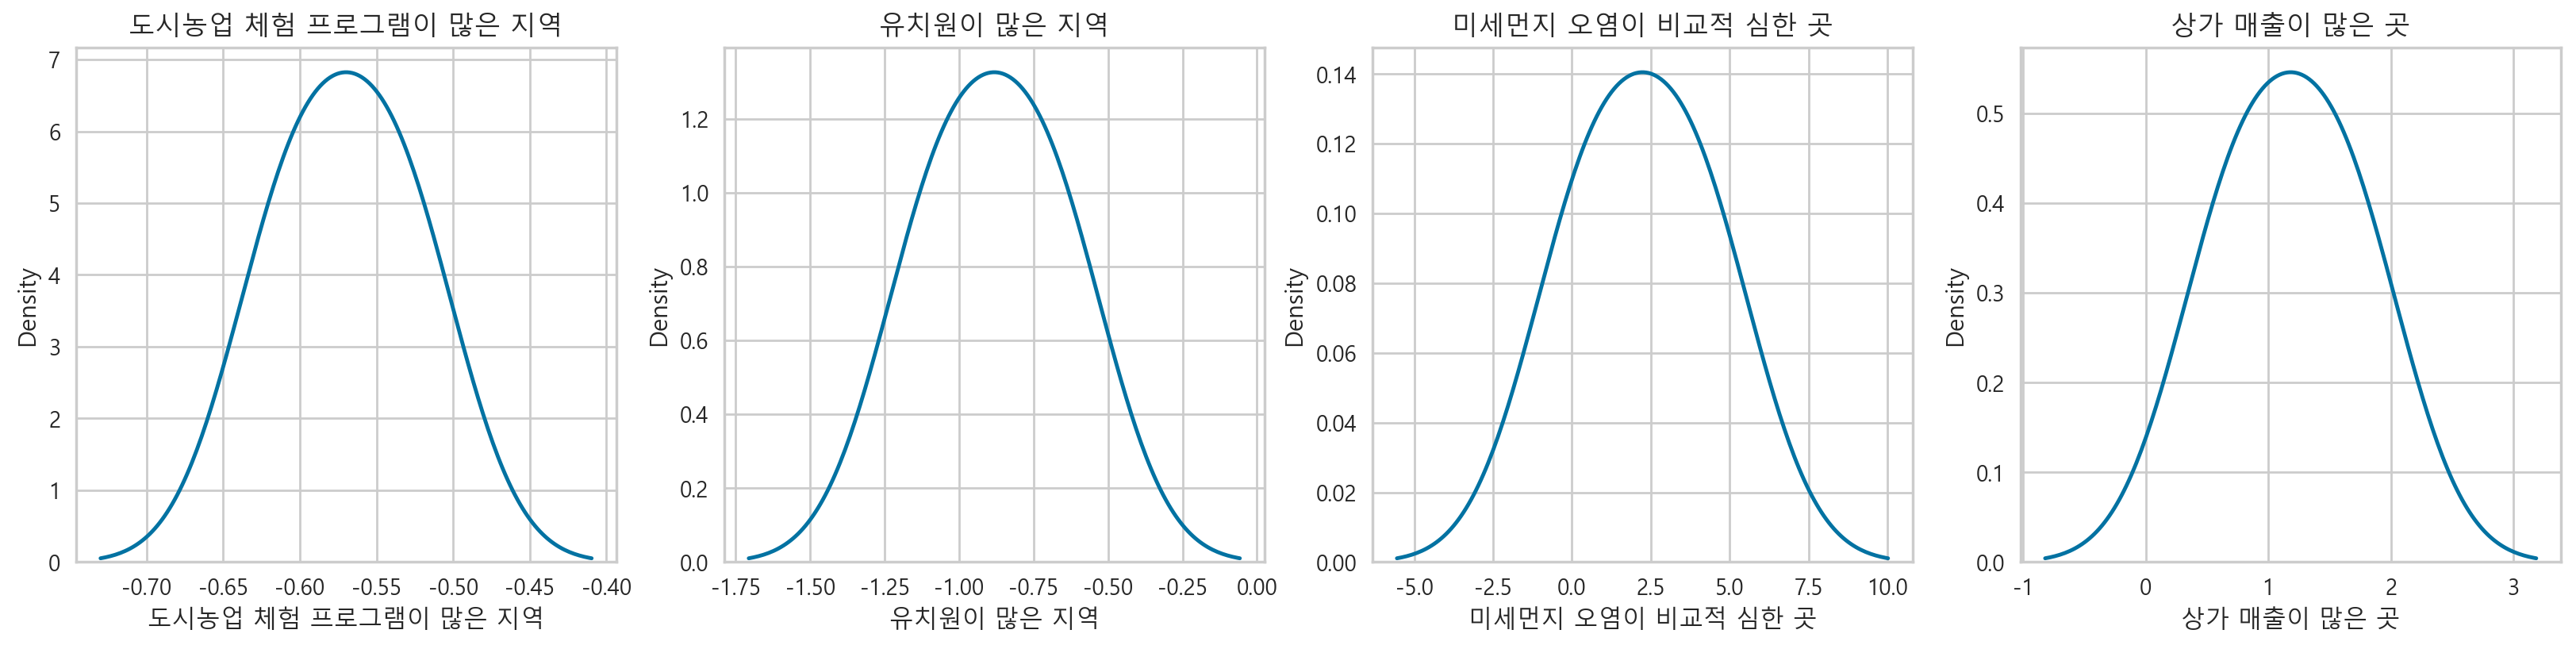

In [33]:
third_group = pca_result[pca_result['cluster'] == 2]
third_group.drop(['silhouette_coeff'], axis = 1, inplace = True)

for row_num in range(4) :
    histplot(third_group.drop(['cluster'], axis = 1), row_num, 4)

### 네번째 Group

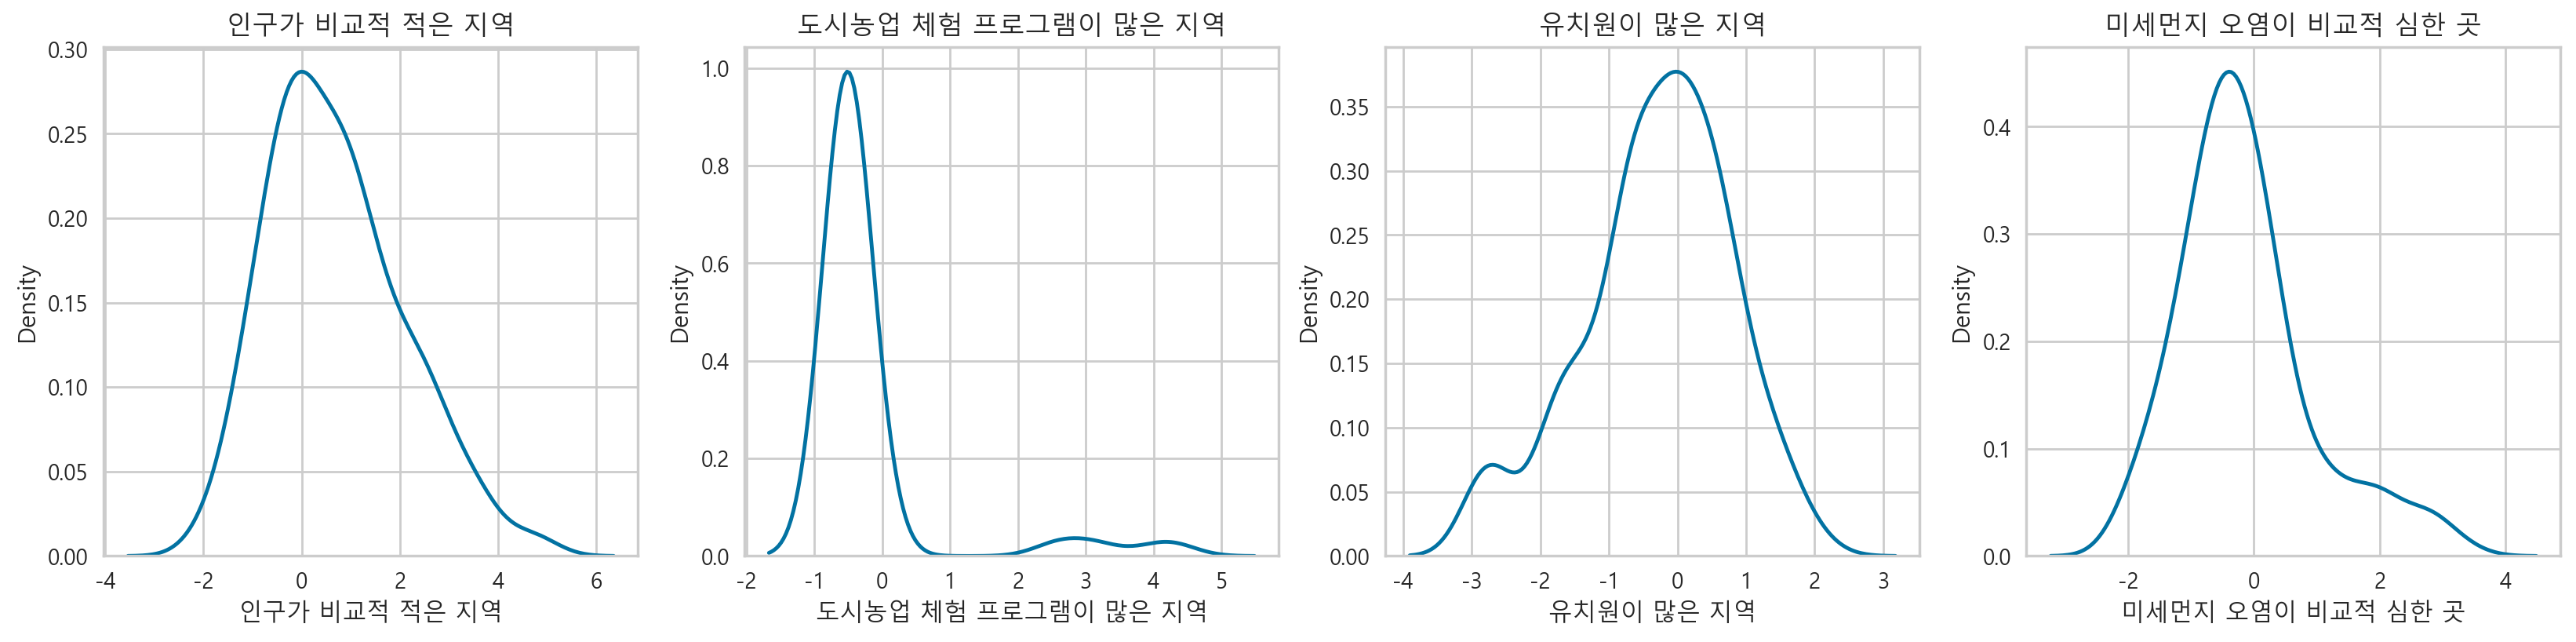

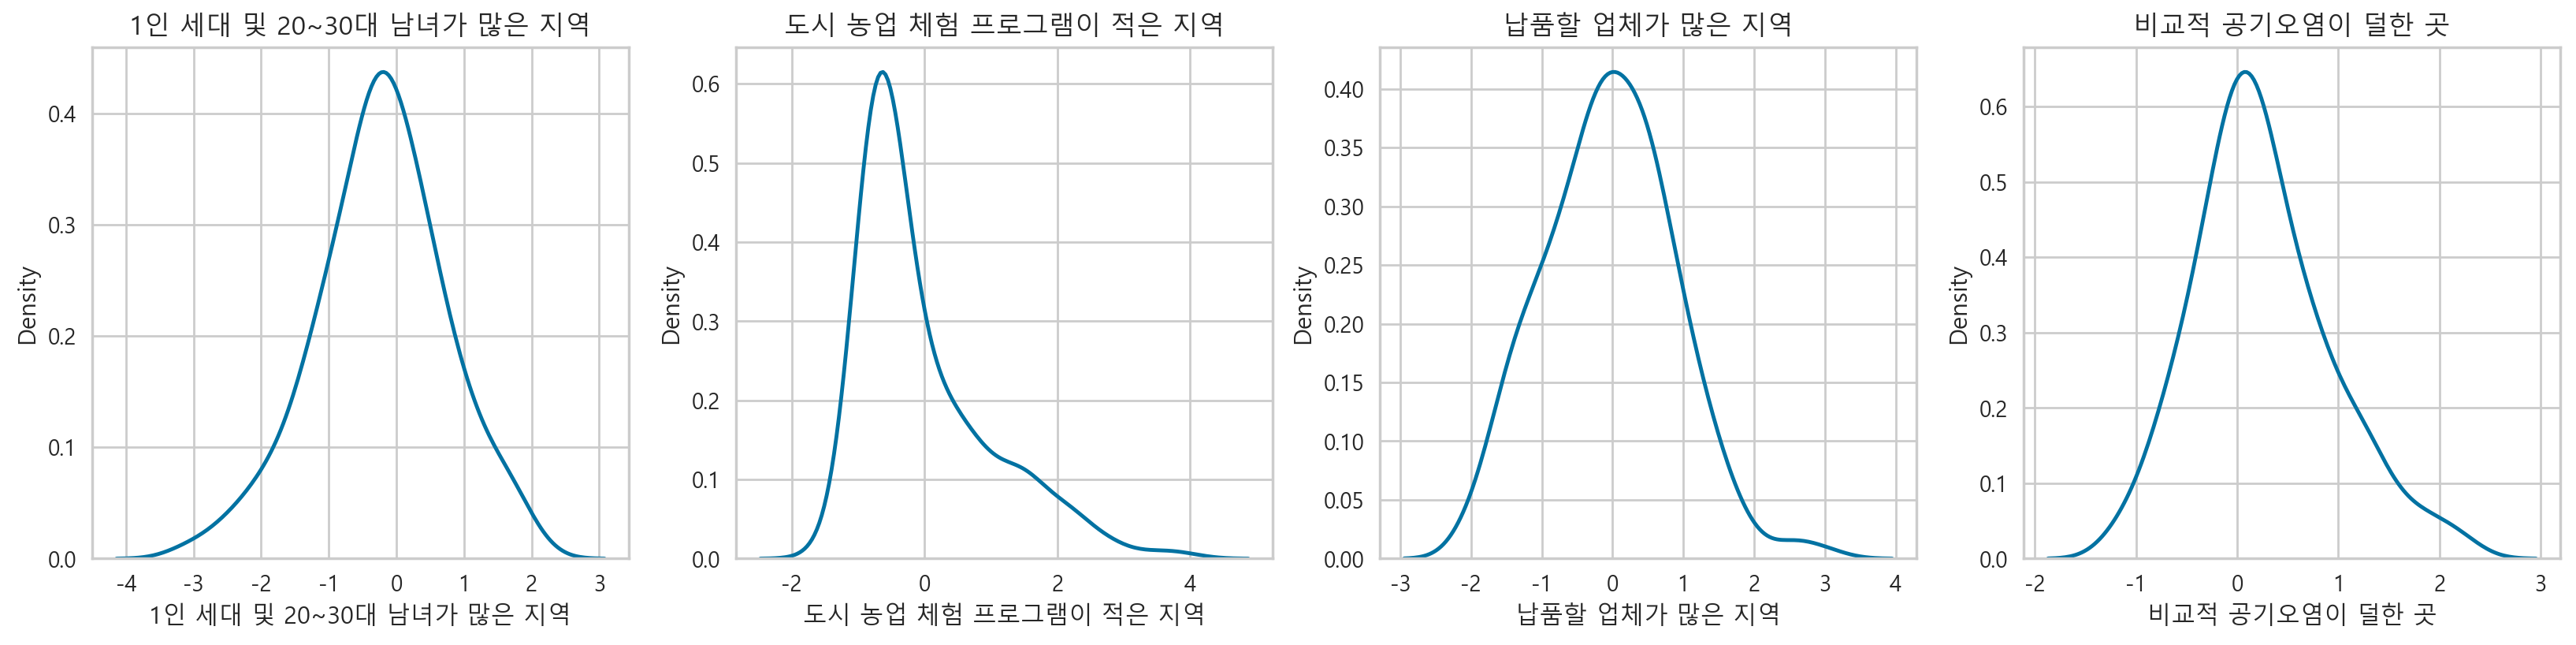

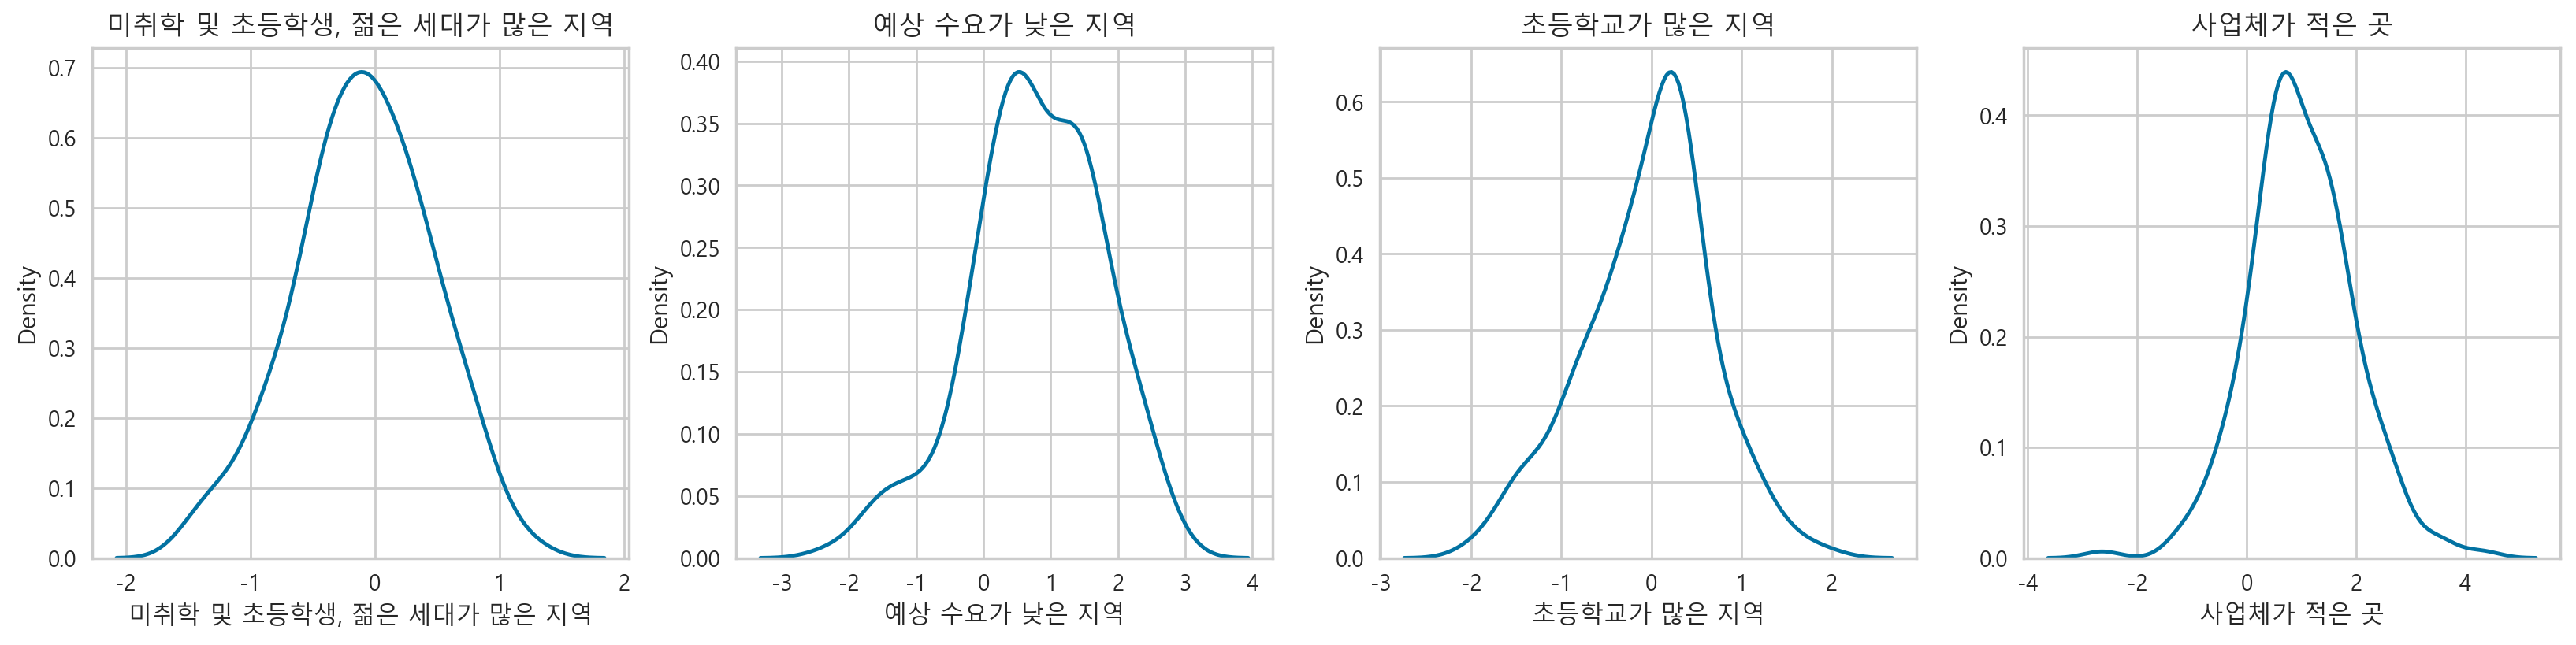

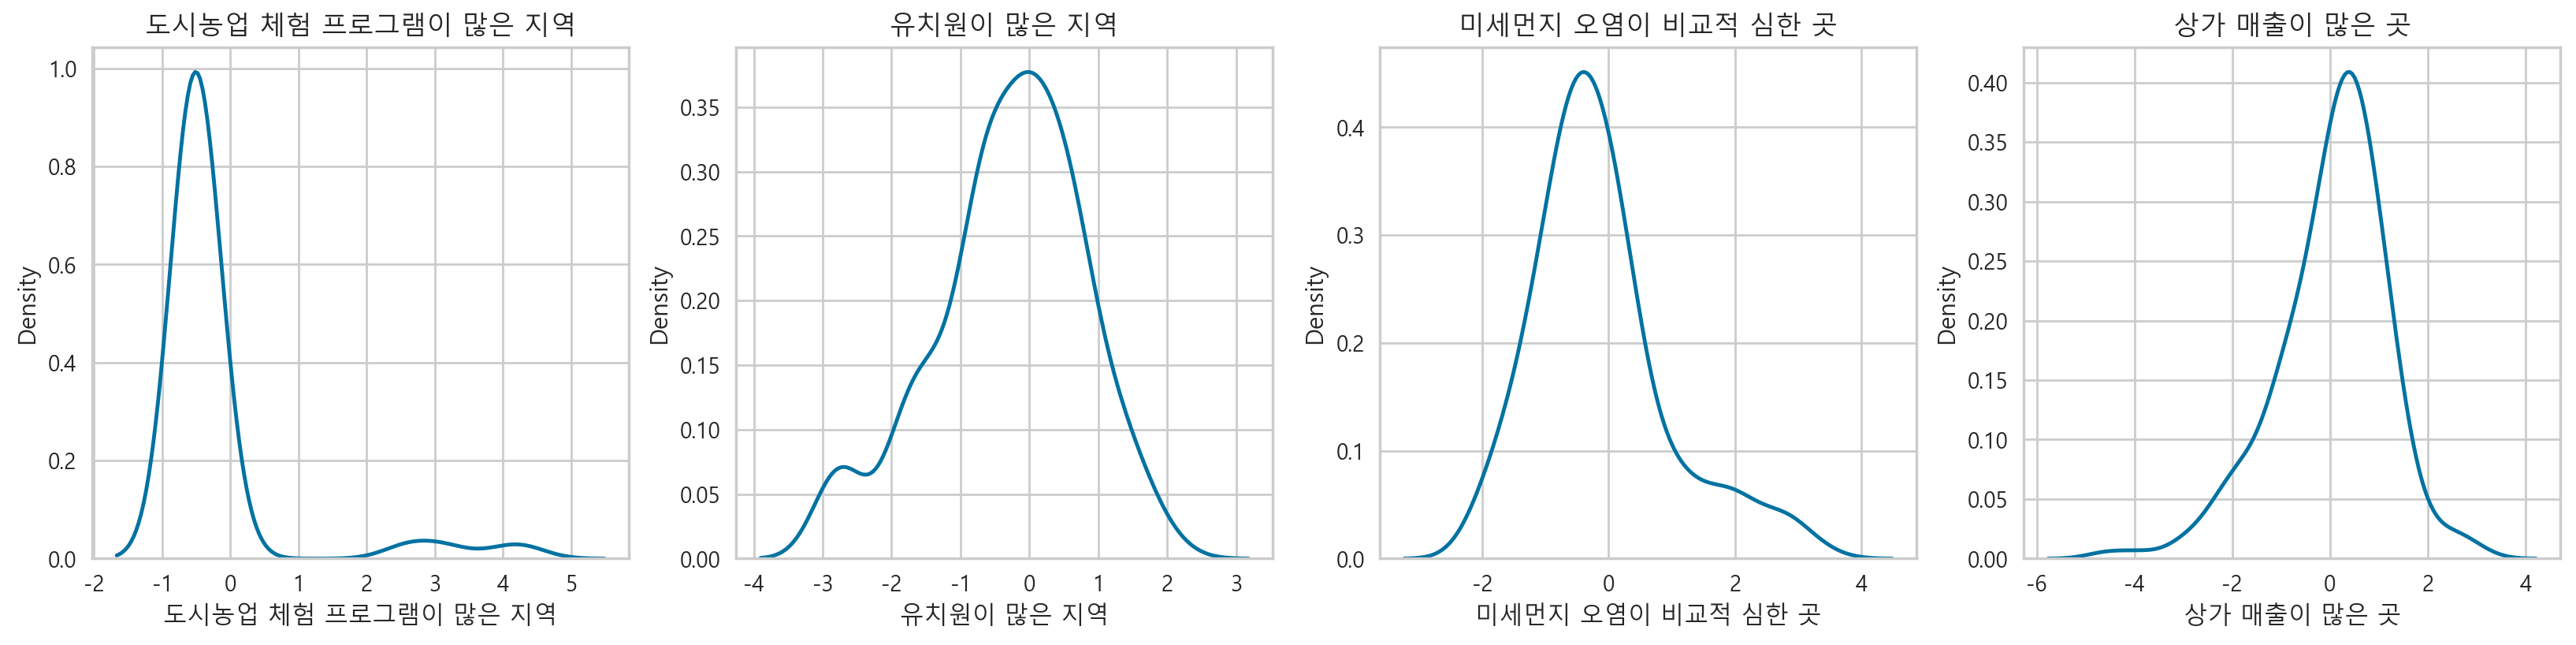

In [34]:
forth_group = pca_result[pca_result['cluster'] == 3]
forth_group.drop(['silhouette_coeff'], axis = 1, inplace = True)

for row_num in range(4) :
    histplot(forth_group.drop(['cluster'], axis = 1), row_num, 4)

In [ ]:
cluster_0 = pca_result[pca_result['cluster'] == 0].index
cluster_1 = pca_result[pca_result['cluster'] == 1].index
cluster_2 = pca_result[pca_result['cluster'] == 2].index
cluster_3 = pca_result[pca_result['cluster'] == 3].index

In [ ]:
cluster_3

Index(['가양2동', '가양3동', '갈현1동', '개봉2동', '개봉3동', '개포2동', '개포3동', '개포4동', '거여1동',
       '거여2동',
       ...
       '홍제2동', '홍제3동', '화곡2동', '화곡3동', '화곡4동', '황학동', '회기동', '효창동', '후암동',
       '휘경1동'],
      dtype='object', length=207)